In [1]:
!pip install datasets einops

In [1]:
import sys
from pathlib import Path

project_root = Path().resolve().parent
sys.path.append(str(project_root))

from models import NotViT

In [2]:
from datasets import load_dataset

# ds = load_dataset("svjack/pokemon-blip-captions-en-zh")['train']
ds = load_dataset("uoft-cs/cifar10")
test = ds['test']
ds = ds['train']

/Users/admin/miniconda3/envs/flux-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib.pyplot as plt
import math
import cv2
import numpy as np
from PIL import Image
from einops import rearrange
from einops.layers.torch import Rearrange

import torch
import torch.nn as nn

from torchvision import transforms as ts

torch.manual_seed(42)

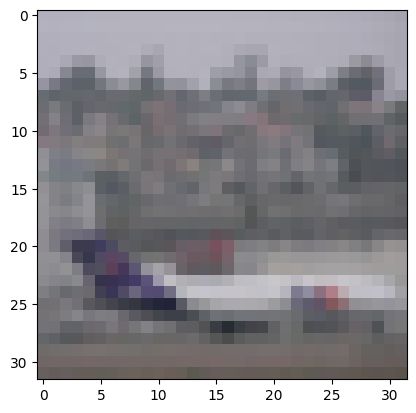

In [4]:
sample_img, label = ds[0].values()
plt.imshow(sample_img)

In [5]:
PATCH_SIZE = 4
BATCH_SIZE = 16
EMBEDDING_SIZE = 128
HEIGHT = 32             # for now
WIDTH = 32              # for now

EPOCHS = 1              
LEARNING_RATE = 1e-3

In [6]:
def ts_resize(examples):
    examples["pixel_values"] = [image.convert("RGB").resize((WIDTH,HEIGHT)) for image in examples["img"]]
    return examples

ds = ds.map(ts_resize, remove_columns=["img"], batched=True)
test = test.map(ts_resize, remove_columns=["img"], batched=True)

In [7]:
def transforms(examples):
    examples["pixel_values"] = [ts.ToTensor()(image.convert("RGB")) for image in examples["pixel_values"]]
    return examples

ds = ds.with_transform(transforms)
test = test.with_transform(transforms)

In [8]:
from torch.utils.data import DataLoader

def collate_fn(examples):
    images = []
    labels = []
    for example in examples:
        images.append((example["pixel_values"]))
        labels.append(example["label"])

    pixel_values = torch.stack(images)
    labels = torch.tensor(labels)
    return {"pixel_values": pixel_values, "label": labels}

dataloader = DataLoader(ds, collate_fn=collate_fn, batch_size=BATCH_SIZE)

test_loader = DataLoader(test, collate_fn=collate_fn, batch_size=BATCH_SIZE)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss()
# As far as we have 10 classes,  estimated CE loss has to be approx. 2.3
vit = NotViT(embed_size=EMBEDDING_SIZE,
                input_h=HEIGHT,
                input_w=WIDTH,
                ).to(device)

optimizer = torch.optim.AdamW(vit.parameters(), lr=LEARNING_RATE)

In [10]:
from tqdm import tqdm

for epoch in range(EPOCHS):
    vit.train()
    train_losses = []

    train_bar = tqdm(dataloader, desc=f"[Epoch {epoch+1}/{EPOCHS}] Train | Loss: ---", leave=False)

    for batch in train_bar:
        optimizer.zero_grad()

        imgs = batch['pixel_values'].to(device)
        targets = batch['label'].to(device)

        outputs = vit(imgs)
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        avg_train_loss = sum(train_losses) / len(train_losses)

        # Обновляем описание прогресс-бара
        train_bar.set_description(f"[Epoch {epoch+1}/{EPOCHS}] Train | Loss: {avg_train_loss:.4f}")

    # Валидация после эпохи
    vit.eval()
    val_losses = []

    val_bar = tqdm(test_loader, desc=f"[Epoch {epoch+1}/{EPOCHS}] Val   | Loss: ---", leave=False)
    with torch.no_grad():
        for val_batch in val_bar:
            val_imgs = val_batch['pixel_values'].to(device)
            val_targets = val_batch['label'].to(device)

            val_output = vit(val_imgs)
            val_loss = loss_fn(val_output, val_targets)

            val_losses.append(val_loss.item())
            avg_val_loss = sum(val_losses) / len(val_losses)

            val_bar.set_description(f"[Epoch {epoch+1}/{EPOCHS}] Val   | Loss: {avg_val_loss:.4f}")

print(f"Train | Loss: {avg_train_loss:.4f}")
print(f"Val | Loss: {avg_val_loss:.4f}")

Train | Loss: 1.9287
Val | Loss: 1.8016
